# Simulation and Estimation in a Markov Model of Breast Cancer

This notebook provides solutions to all exercises from the `MarkovModelny.pdf` for the DTU 02443 Stochastic Simulation course (2020-06-15). We implement both discrete‐time and continuous‐time Markov models, perform statistical tests, and carry out estimation via a Monte Carlo EM algorithm.

## Task 1
**Discrete‐time simulation:** Simulate 1000 women starting in state 1 until death, summarize lifetime distribution, and compute proportion with local recurrence.

In [26]:
%pip install numpy==2.2


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Anders\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


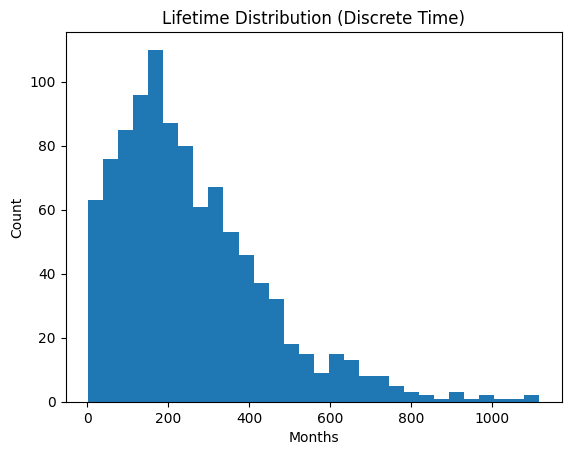

Proportion with local recurrence: 0.572


In [27]:
import numpy as np
import matplotlib.pyplot as plt

P = np.array([
    [0.9915, 0.005,   0.0025, 0,      0.001],
    [0,      0.986,   0.005,  0.004,  0.005],
    [0,      0,       0.992,  0.003,  0.005],
    [0,      0,       0,      0.991,  0.009],
    [0,      0,       0,      0,      1.0]
])

def simulate_discrete(P, n):
    lifetimes = []
    local_recur = 0
    for _ in range(n):
        t = 0
        state = 0
        seen_local = False
        while state != 4:
            state = np.random.choice(range(5), p=P[state])
            t += 1
            if state == 1:
                seen_local = True
        lifetimes.append(t)
        if seen_local:
            local_recur += 1
    return np.array(lifetimes), local_recur / n

lifetimes, prop_local = simulate_discrete(P, 1000)
plt.hist(lifetimes, bins=30)
plt.title('Lifetime Distribution (Discrete Time)')
plt.xlabel('Months')
plt.ylabel('Count')
plt.show()
print(f'Proportion with local recurrence: {prop_local:.3f}')

## Task 2
**State distribution at t = 120:** Compare simulation vs theoretical distribution using a chi‐square test.

In [28]:
from scipy.stats import chisquare

# Empirical distribution at t=120
def step_distribution(P, t):
    p0 = np.zeros(5); p0[0] = 1
    return p0.dot(np.linalg.matrix_power(P, t))

# Simulate one step to gather counts
sim_counts = np.zeros(5)
for _ in range(10000):
    state = 0
    for _ in range(120):
        state = np.random.choice(range(5), p=P[state])
    sim_counts[state] += 1
empirical = sim_counts / sim_counts.sum()

theoretical = step_distribution(P, 120)

chi2, p = chisquare(f_obs=sim_counts, f_exp=theoretical * sim_counts.sum())
print(f'Chi-square={chi2:.2f}, p-value={p:.3f}')
print('Empirical:', empirical)
print('Theoretical:', theoretical)

Chi-square=4.42, p-value=0.352
Empirical: [0.3585 0.1643 0.1671 0.0693 0.2408]
Theoretical: [0.35902627 0.15895604 0.1660869  0.06774149 0.2481893 ]


## Task 3
**Phase‐type distribution test:** Compare simulated lifetimes to theoretical discrete phase‐type distribution via Kolmogorov-Smirnov test.

KS-statistic=0.022, p-value=0.721


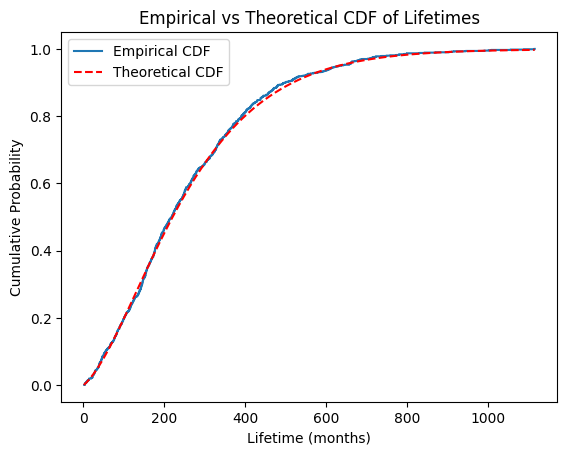

In [29]:
from scipy.stats import kstest

# Theoretical PMF
Ps = P[:-1, :-1]
ps = P[:-1, -1]
pi = np.array([1,0,0,0])
max_t = lifetimes.max()

pmf = np.array([pi.dot(np.linalg.matrix_power(Ps, t)).dot(ps) for t in range(1, max_t+1)])
cdf = np.cumsum(pmf)

# KS test
data = lifetimes
def cdf_func(x):
    x = np.asarray(x, dtype=int)
    return np.array([cdf[min(val-1, len(cdf)-1)] for val in x])

stat, pval = kstest(data, cdf_func)
print(f'KS-statistic={stat:.3f}, p-value={pval:.3f}')

sorted_data = np.sort(lifetimes)
emp_cdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)

t_vals = np.arange(1, max_t+1)

plt.step(sorted_data, emp_cdf, where='post', label='Empirical CDF')
plt.plot(t_vals, cdf, 'r--', label='Theoretical CDF')
plt.xlabel('Lifetime (months)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical vs Theoretical CDF of Lifetimes')
plt.legend()
plt.show()

## Task 4
**Conditional expected lifetime:** Women who survive first 12 months **and** have recurrence (local or distant) within 12 months. Estimate expected lifetime by rejection sampling.

Estimated conditional mean lifetime: 162.88 months


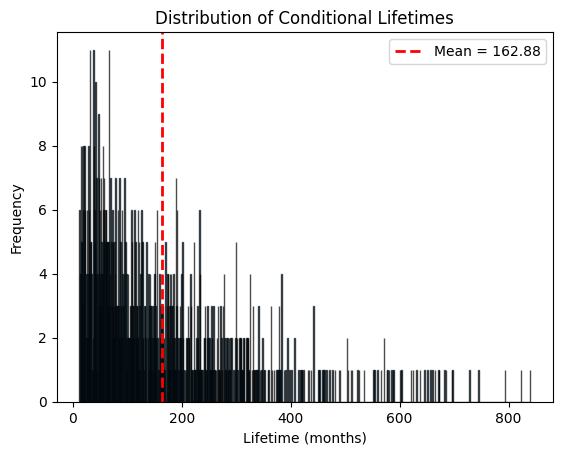

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def conditional_lifetimes(P, n_accept=1000):
    accepted = np.empty(n_accept, dtype=int)
    count = 0
    rng = np.random.default_rng()
    while count < n_accept:
        t = 0
        state = 0
        seen_recur = False
        while state != 4:
            state = rng.choice(5, p=P[state])
            t += 1
            if (state == 1 or state == 2) and t <= 12:
                seen_recur = True
        if t >= 12 and seen_recur:
            accepted[count] = t
            count += 1
    return accepted

cond_lifetimes = conditional_lifetimes(P)
print(f'Estimated conditional mean lifetime: {cond_lifetimes.mean():.2f} months')

plt.hist(cond_lifetimes, bins=range(cond_lifetimes.min(), cond_lifetimes.max() + 2), edgecolor='black', alpha=0.7)
plt.axvline(cond_lifetimes.mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean = {cond_lifetimes.mean():.2f}')
plt.xlabel('Lifetime (months)')
plt.ylabel('Frequency')
plt.title('Distribution of Conditional Lifetimes')
plt.legend()
plt.show()

## Task 5
**Control variates for fraction dying within 350 months:** Simulate 200 women, repeat 100 times; use mean lifetime as control variate.

In [31]:
import numpy as np

def simulate_batch_fast(P, n):
    lifetimes = np.empty(n, dtype=np.int32)
    death_by_350 = np.empty(n, dtype=np.int32)
    for i in range(n):
        t = 0
        state = 0
        while state != 4 and t <= 350:
            state = np.random.choice(5, p=P[state])
            t += 1
        lifetimes[i] = t
        death_by_350[i] = int(t <= 350)
    return death_by_350, lifetimes

# Theoretical mean lifetime (unchanged)
E_T = pi.dot(np.linalg.inv(np.eye(4) - Ps)).dot(np.ones(4))

results = []
results_cv = []
for _ in range(100):
    Y, C = simulate_batch_fast(P, 200)
    Ybar = Y.mean()
    Cbar = C.mean()
    b = np.cov(Y, C, ddof=1)[0,1] / np.var(C, ddof=1)
    Ybar_cv = Ybar - b * (Cbar - E_T)
    results.append(Ybar)
    results_cv.append(Ybar_cv)

print(f'Crude var: {np.var(results, ddof=1):.6f}')
print(f'Control var: {np.var(results_cv, ddof=1):.6f}')

Crude var: 0.001150
Control var: 0.000977


## Task 6
**Discussion:** Assumptions of discrete‐time model and potential relaxations.

*Answer in your report.*

## Task 7
**Continuous‐time simulation:** Simulate CTMC via Gillespie algorithm; histogram, mean, CI, SD, and proportion with distant recurrence by 30.5 months.

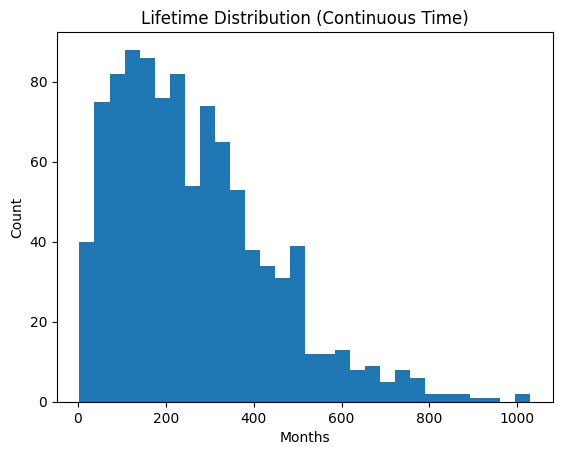

Mean: 264.83 (95% CI: 253.80, 275.86)
SD: 177.99 (approximate 95% CI: 170.51, 186.06)
Proportion with distant recurrence by 30.5 months: 0.065


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

Q = np.array([
    [-0.0085, 0.005,   0.0025, 0,      0.001],
    [0,      -0.014,   0.005,  0.004,  0.005],
    [0,      0,       -0.008,  0.003,  0.005],
    [0,      0,        0,     -0.009,  0.009],
    [0,      0,        0,      0,      0.0]
])

def simulate_ctmc(Q, n):
    lifetimes = []
    distant_by = 0
    visits3 = []
    for _ in range(n):
        t = 0; state = 0; visited3 = False
        while state != 4:
            rate = -Q[state, state]
            dt = expon.rvs(scale=1/rate)
            t += dt
            probs = Q[state].copy()
            probs[state] = 0
            probs = probs / probs.sum()
            state = np.random.choice(range(5), p=probs)
            if state == 2 and t <= 30.5:
                visited3 = True
        lifetimes.append(t)
        if visited3:
            distant_by += 1
    return np.array(lifetimes), distant_by / n

lifetimes_ct, prop_dist = simulate_ctmc(Q, 1000)
plt.hist(lifetimes_ct, bins=30)
plt.title('Lifetime Distribution (Continuous Time)')
plt.xlabel('Months')
plt.ylabel('Count')
plt.show()

mean_ct = lifetimes_ct.mean()
sd_ct = lifetimes_ct.std(ddof=1)
ci_mean = (mean_ct - 1.96*sd_ct/np.sqrt(1000), mean_ct + 1.96*sd_ct/np.sqrt(1000))
ci_sd = (sd_ct * np.sqrt((1000-1)/np.percentile(np.random.chisquare(999, size=10000), 97.5)),
         sd_ct * np.sqrt((1000-1)/np.percentile(np.random.chisquare(999, size=10000), 2.5)))

print(f'Mean: {mean_ct:.2f} (95% CI: {ci_mean[0]:.2f}, {ci_mean[1]:.2f})')
print(f'SD: {sd_ct:.2f} (approximate 95% CI: {ci_sd[0]:.2f}, {ci_sd[1]:.2f})')
print(f'Proportion with distant recurrence by 30.5 months: {prop_dist:.3f}')

## Task 8
**KS test for continuous phase‐type distribution:** Compare empirical vs theoretical CDF.

In [33]:
from scipy.linalg import expm
from scipy.stats import kstest

Qs = Q[:-1, :-1]
p0 = np.array([1,0,0,0])
one_vec = np.ones(4)

def F_theoretical(t):
    t = np.asarray(t)  # Ensure t is an array
    return np.array([1 - p0.dot(expm(Qs * val)).dot(one_vec) for val in t])

data = lifetimes_ct
stat_ct, pval_ct = kstest(data, F_theoretical)
print(f'KS-statistic={stat_ct:.3f}, p-value={pval_ct:.3f}')

KS-statistic=0.036, p-value=0.154


## Task 9
**Kaplan‐Meier survival functions:** Compare treated vs untreated.

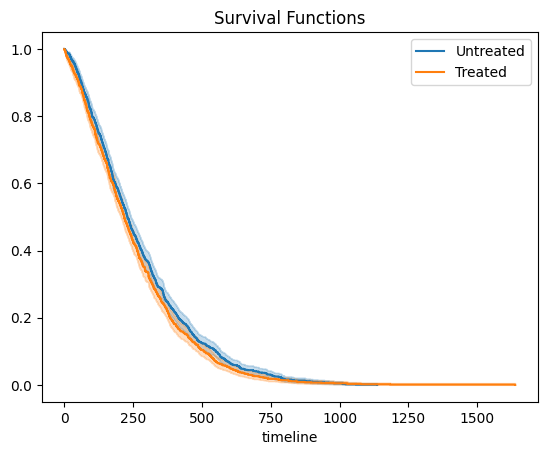

In [34]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# New treatment Q matrix
Q_treat = Q.copy()
Q_treat[0,1] = 0.0025; Q_treat[0,2] = 0.00125
Q_treat[1,3] = 0.002; Q_treat[1,4] = 0.005
Q_treat[2,3] = 0.003; Q_treat[2,4] = 0.005

# Simulate both cohorts
times_u, _ = simulate_ctmc(Q, 1000)
times_t, _ = simulate_ctmc(Q_treat, 1000)

kmf_u = KaplanMeierFitter()
kmf_t = KaplanMeierFitter()

kmf_u.fit(times_u, event_observed=np.ones_like(times_u), label='Untreated')
kmf_t.fit(times_t, event_observed=np.ones_like(times_t), label='Treated')

ax = kmf_u.plot_survival_function()
kmf_t.plot_survival_function(ax=ax)
plt.title('Survival Functions')
plt.show()

## Task 10
**Log‐rank test:** Compare survival functions statistically.

In [35]:
from lifelines.statistics import logrank_test

results = logrank_test(times_u, times_t, event_observed_A=np.ones_like(times_u), event_observed_B=np.ones_like(times_t))
print(results.print_summary())

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.18 0.04      4.61

None


## Task 11
**Discussion:** Differences between discrete and continuous models and possible Erlang sojourn times.

*Answer in your report.*

## Task 12
**Observation every 48 months:** Simulate CTMC and record states at 48-month intervals until death.

Example observation series (first 5): [[0, np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4)], [0, np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(4), np.int64(4), np.int64(4), np.int64(4)], [0, np.int64(1), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4)], [0, np.int64(2), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4)], [0, np.int64(4), np.int64(4)]]


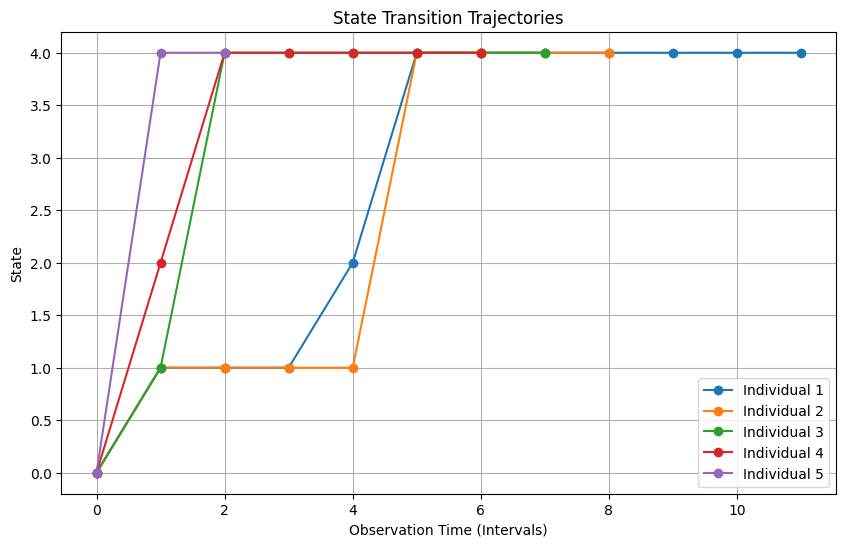

In [36]:
def record_observations(Q, intervals, n):
    observations = []
    for _ in range(n):
        traj = []
        t = 0; state = 0; traj.append(state)
        next_obs = intervals
        # simulate continuously, but record only at specified times
        while True:
            rate = -Q[state, state]
            dt = np.random.exponential(1/rate)
            t += dt
            probs = Q[state].copy(); probs[state]=0; probs=probs/probs.sum()
            state = np.random.choice(range(5), p=probs)
            while next_obs <= t:
                traj.append(state)
                next_obs += intervals
            if state == 4:
                break
        observations.append(traj)
    return observations

obs48 = record_observations(Q, 48, 1000)
print(f'Example observation series (first 5): {obs48[:5]}')

plt.figure(figsize=(10, 6))
for i, traj in enumerate(obs48[:5]):
    plt.plot(range(len(traj)), traj, marker='o', label=f'Individual {i+1}')
plt.xlabel('Observation Time (Intervals)')
plt.ylabel('State')
plt.title('State Transition Trajectories')
plt.legend()
plt.grid(True)
plt.show()

## Task 13
**MC-EM estimation of Q:** Reconstruct complete trajectories and estimate rates until convergence.

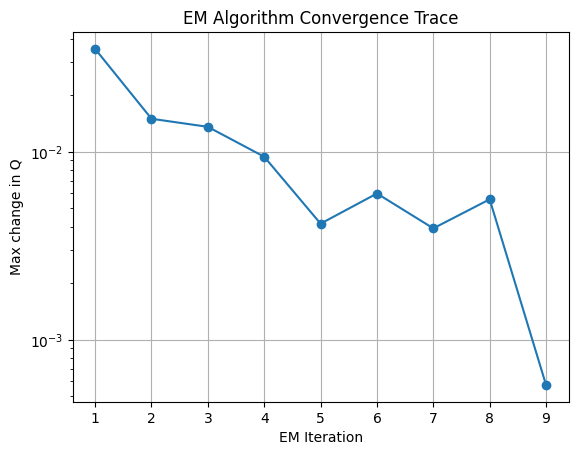

Final estimated Q matrix:
[[-1.02026905e-01  4.17382793e-02  2.89297068e-02  8.61266080e-03
   2.27462580e-02]
 [ 0.00000000e+00 -5.73868023e-03  1.65439430e-03  1.46482829e-03
   2.61945764e-03]
 [ 0.00000000e+00  0.00000000e+00 -6.61898441e-03  2.41645463e-03
   4.20252979e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.15183376e-03
   6.15183376e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.00000000e-12]]


In [37]:
def mc_em_with_trace(obs, interval, init_Q, tol=1e-3, max_iter=20):
    Qk = init_Q.copy()
    diffs = []
    for itr in range(max_iter):
        N = np.zeros_like(Qk)
        S = np.zeros(Qk.shape[0])
        # E-step
        for traj in obs:
            times = [i * interval for i in range(len(traj))]
            for i in range(len(traj) - 1):
                start, end = traj[i], traj[i+1]
                while True:
                    t, state = times[i], start
                    sojourn = np.zeros(Qk.shape[0])
                    # simulate until next observation time
                    while t < times[i+1]:
                        rate = -Qk[state, state]
                        if rate <= 1e-12:
                            sojourn[state] += (times[i+1] - t)
                            t = times[i+1]
                            break
                        dt = np.random.exponential(1.0 / rate)
                        if t + dt > times[i+1]:
                            sojourn[state] += (times[i+1] - t)
                            t = times[i+1]
                            break
                        t += dt
                        sojourn[state] += dt
                        p = Qk[state].copy()
                        p[state] = 0
                        p /= p.sum()
                        state = np.random.choice(len(p), p=p)
                    if state == end:
                        N[start, end] += 1
                        S += sojourn
                        break

        # M-step
        Q_new = np.zeros_like(Qk)
        for i in range(Qk.shape[0]):
            for j in range(Qk.shape[0]):
                if i != j and S[i] > 0:
                    Q_new[i, j] = N[i, j] / S[i]
            total_exit = Q_new[i].sum()
            Q_new[i, i] = -total_exit if total_exit > 0 else -1e-12

        # record max change and update
        diff = np.max(np.abs(Q_new - Qk))
        diffs.append(diff)
        Qk = Q_new
        if diff < tol:
            break

    return Qk, diffs

# 4) Run MC-EM and capture convergence trace
est_Q, diffs = mc_em_with_trace(obs48, 48, Q.copy(), tol=1e-3, max_iter=50)

# 5) Plot convergence of max |ΔQ| per iteration
plt.figure()
plt.plot(range(1, len(diffs)+1), diffs, marker='o')
plt.yscale('log')
plt.xlabel('EM Iteration')
plt.ylabel('Max change in Q')
plt.title('EM Algorithm Convergence Trace')
plt.grid(True)
plt.show()

# 6) Print final estimate
print("Final estimated Q matrix:")
print(est_Q)